<a href="https://colab.research.google.com/github/ada-my619/Rock-Classification/blob/main/Rock_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Fabric Classification

## Import the data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanyadayanand/geological-image-similarity")

print("Path to dataset files:", path)

100%|██████████| 33.6M/33.6M [00:00<00:00, 83.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tanyadayanand/geological-image-similarity/versions/1


In [2]:
import os

os.listdir(path)

['geological_similarity']

In [3]:
count = 0
limit = 2
for folder in os.listdir(path):
    print(f"\n📁 {folder}")
    # print(os.listdir(os.path.join(path, folder)))
    for subfolder in os.listdir(os.path.join(path, folder)):
        print(f"  📁 {subfolder}")
        # print(os.listdir(os.path.join(path, folder, subfolder)))
        count = 0
        for file in os.listdir(os.path.join(path, folder, subfolder)):
            if count < limit:
              print(f"    📄 {file}")
            else:
              print("     ....")
              break
            count += 1



📁 geological_similarity
  📁 gneiss
    📄 WLKFM.jpg
    📄 O2Q5M.jpg
     ....
  📁 schist
    📄 T3X2K.jpg
    📄 SHCX1.jpg
     ....
  📁 quartzite
    📄 OXJ72.jpg
    📄 S648P.jpg
     ....
  📁 marble
    📄 A7J36.jpg
    📄 TMV4T.jpg
     ....
  📁 rhyolite
    📄 16SD5.jpg
    📄 J2QIO.jpg
     ....
  📁 andesite
    📄 7CXF2.jpg
    📄 OPX5F.jpg
     ....


Dataset ImageFolder
    Number of datapoints: 29998
    Root location: /root/.cache/kagglehub/datasets/tanyadayanand/geological-image-similarity/versions/1/geological_similarity
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 

{'andesite': 0, 'gneiss': 1, 'marble': 2, 'quartzite': 3, 'rhyolite': 4, 'schist': 5}
torch.Size([3, 28, 28])
0


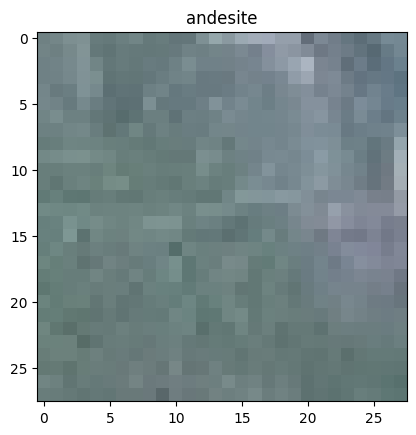

In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

transform = transforms.Compose([
        transforms.ToTensor(),
    ])

rock_dataset = ImageFolder(root=os.path.join(path, "geological_similarity"), transform=transform)

print(rock_dataset, "\n")
print(rock_dataset.class_to_idx)

rock, target = rock_dataset[0]
print(rock.shape)
print(target)
plt.imshow(rock.permute(1, 2, 0))
plt.title(list(rock_dataset.class_to_idx)[target])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

def split_dataset(dataset, train_size=0.7, val_size=0.2, test_size=0.1, seed=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6 # "train, val, and test sizes must sum to 1"

    targets = [label for _, label in dataset.samples]
    indices = np.arange(len(targets))

    train_idx, temp_idx = train_test_split(
        indices,
        test_size=(1.0 - train_size),
        stratify=targets,
        random_state=seed
    )

    # split temp into val and test
    temp_targets = [targets[i] for i in temp_idx]
    val_ratio = val_size / (val_size + test_size)

    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=(1.0 - val_ratio),
        stratify=temp_targets,
        random_state=seed
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset   = Subset(dataset, val_idx)
    test_dataset  = Subset(dataset, test_idx)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(rock_dataset)
print(len(train_dataset), len(val_dataset), len(test_dataset))

20998 5999 3001


In [6]:
idx_to_class = {v: k for k, v in rock_dataset.class_to_idx.items()}
from collections import Counter

def print_class_proportion(dataset, name):
    labels = [dataset[i][1] for i in range(len(dataset))]
    counts = Counter(labels)
    total = len(labels)

    print(f"\n{name} (total = {total})")
    for label, count in sorted(counts.items()):
        class_name = idx_to_class[label]
        print(f"  {class_name:<10}: {count:>4} ({count/total:.2%})")
print_class_proportion(rock_dataset, "Full dataset")
print_class_proportion(train_dataset, "Train dataset")
print_class_proportion(val_dataset, "Validation dataset")
print_class_proportion(test_dataset, "Validation dataset")



Full dataset (total = 29998)
  andesite  : 5000 (16.67%)
  gneiss    : 5000 (16.67%)
  marble    : 4998 (16.66%)
  quartzite : 5000 (16.67%)
  rhyolite  : 5000 (16.67%)
  schist    : 5000 (16.67%)

Train dataset (total = 20998)
  andesite  : 3500 (16.67%)
  gneiss    : 3500 (16.67%)
  marble    : 3498 (16.66%)
  quartzite : 3500 (16.67%)
  rhyolite  : 3500 (16.67%)
  schist    : 3500 (16.67%)

Validation dataset (total = 5999)
  andesite  : 1000 (16.67%)
  gneiss    : 1000 (16.67%)
  marble    : 1000 (16.67%)
  quartzite :  999 (16.65%)
  rhyolite  : 1000 (16.67%)
  schist    : 1000 (16.67%)

Validation dataset (total = 3001)
  andesite  :  500 (16.66%)
  gneiss    :  500 (16.66%)
  marble    :  500 (16.66%)
  quartzite :  501 (16.69%)
  rhyolite  :  500 (16.66%)
  schist    :  500 (16.66%)


In [7]:
batch_size = 32

In [8]:
from torch.utils.data import DataLoader
import torch

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)
n_pixels = 0

for images, _ in loader:
    # images shape: (B, C, H, W)
    b, c, h, w = images.shape
    pixels = b * h * w
    n_pixels += pixels

    mean += images.sum(dim=[0, 2, 3])
    std  += (images ** 2).sum(dim=[0, 2, 3])

mean /= n_pixels
std = torch.sqrt(std / n_pixels - mean ** 2)

print(mean, std)

tensor([0.5081, 0.5197, 0.5193]) tensor([0.1860, 0.1984, 0.2188])


In [9]:
from numpy import random
import matplotlib.pyplot as plt

def get_classes(dataset):
    if hasattr(dataset, "classes"):
        return dataset.classes
    elif hasattr(dataset, "dataset") and hasattr(dataset.dataset, "classes"):
        return dataset.dataset.classes
    else:
        raise AttributeError("Dataset has no classes attribute")


def show_batch(dataset, nr=4, nc=4):
    classes = get_classes(dataset)

    fig, axarr = plt.subplots(nr, nc, figsize=(5, 5))
    for i in range(nr):
        for j in range(nc):
            idx = random.randint(0, len(dataset))
            sample, target = dataset[idx]

            # normalize for display if needed
            if sample.min() < 0.:
                sample = (sample - sample.min()) / (sample.max() - sample.min())

            # show image
            if sample.ndim == 3:
                axarr[i][j].imshow(sample.permute(1, 2, 0))
            else:
                axarr[i][j].imshow(sample)

            target_name = classes[target]
            axarr[i][j].set_title(f"{target_name} ({target})")
            axarr[i][j].axis("off")

    fig.tight_layout(pad=1.5)
    plt.show()


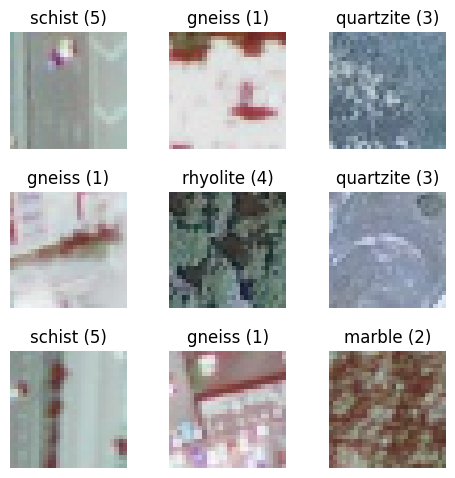

In [10]:
show_batch(train_dataset, 3, 3)

In [11]:
# Finally add normalisation to transforms
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

rock_dataset = ImageFolder(root=os.path.join(path, "geological_similarity"), transform=transform)

train_dataset, val_dataset, test_dataset = split_dataset(rock_dataset)
print(len(train_dataset), len(val_dataset), len(test_dataset))

20998 5999 3001


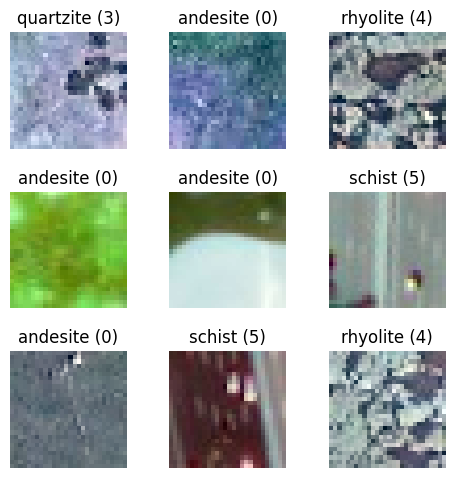

In [12]:
show_batch(train_dataset, 3, 3)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
!pip install pycm livelossplot
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 22.9 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mean', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [15]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [16]:
set_seed(42)

True

In [17]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # print(X.shape)
        a2 = model(X.view(-1, 3, 28, 28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss.item()*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    with torch.no_grad():
      for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 28, 28))
            loss = criterion(a2, y)
            validation_loss += loss.item()*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 28, 28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

## Baseline CNN

In [66]:
class SmallCNN(nn.Module):
    def __init__(self, in_channels=3, out=6, embedding_dim=256):
        super().__init__()

        # Conv layer
        self.features = nn.Sequential(
            # Block 1: 28x28 -> 28x28
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            # Block 2: 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            # Block 3: 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )

        # Embedding Layer
        self.flatten = nn.Flatten()
        self.embedding = nn.Linear(128 * 7 * 7, embedding_dim)

        # Class layer
        self.class_layer = nn.Linear(embedding_dim, out)
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.embedding(x)
        x = self.class_layer(x)
        return x


In [70]:
lr = 1e-6
n_epochs = 20

In [71]:
small_cnn = SmallCNN().to(device)
summary(small_cnn, input_size=(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 64, 28, 28]          18,496
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
      BatchNorm2d-10          [-1, 128, 14, 14]             256
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Flatten-12                 [-1, 6272]               0
           Linear-13                  [-1, 256]       1,605,888
           Linear-14                   

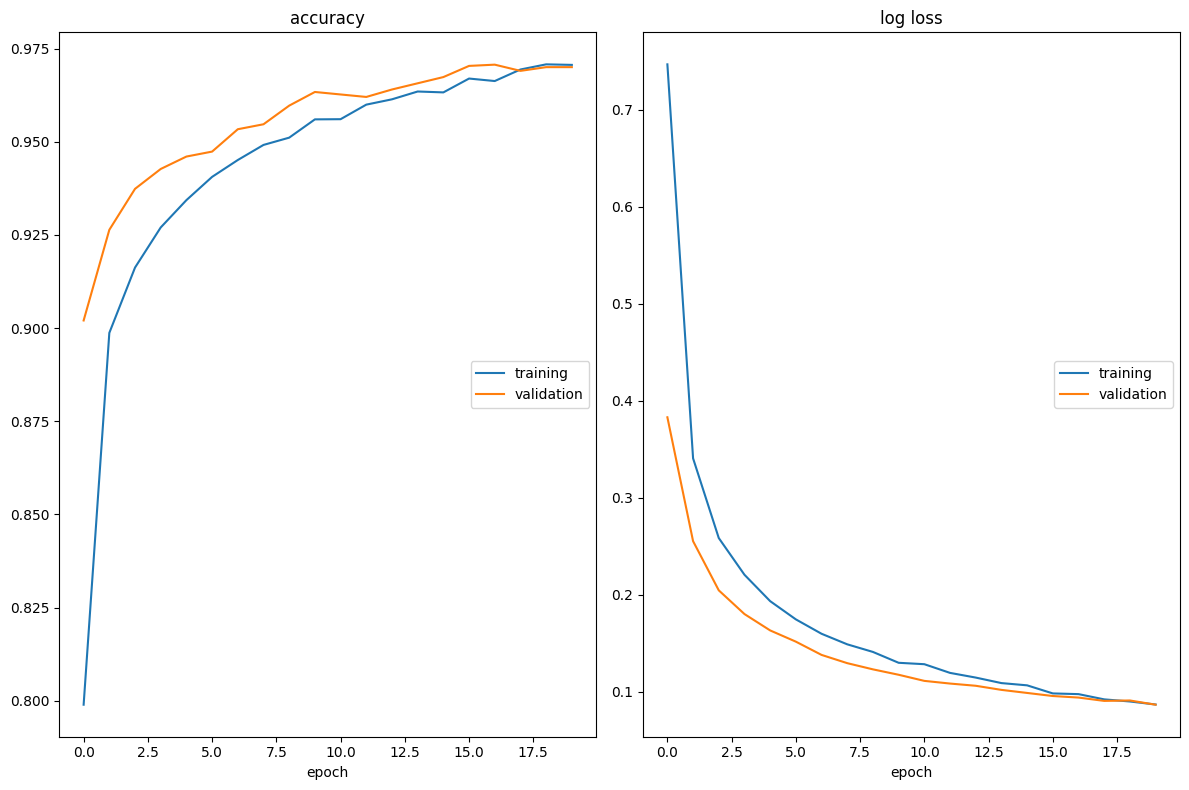

accuracy
	training         	 (min:    0.799, max:    0.971, cur:    0.971)
	validation       	 (min:    0.902, max:    0.971, cur:    0.970)
log loss
	training         	 (min:    0.087, max:    0.747, cur:    0.087)
	validation       	 (min:    0.087, max:    0.383, cur:    0.087)
Avg. Test Loss: 0.087  Avg. Test Accuracy: 0.970



In [72]:
optimizer = torch.optim.Adam(small_cnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(small_cnn, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(small_cnn, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(small_cnn, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss, " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       500
           1       0.97      0.97      0.97       500
           2       1.00      1.00      1.00       500
           3       0.97      0.97      0.97       501
           4       0.97      0.98      0.98       500
           5       0.97      0.95      0.96       500

    accuracy                           0.97      3001
   macro avg       0.97      0.97      0.97      3001
weighted avg       0.97      0.97      0.97      3001



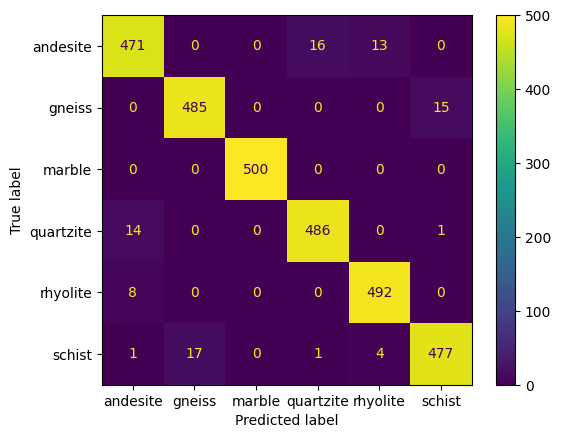

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# create the confusion matrix for prediction
y_pred, y_true = evaluate(small_cnn, test_loader)

cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))
# make the label 0, 1, 2,... to folder name
cm.ax_.set_xticklabels(list(rock_dataset.class_to_idx))
cm.ax_.set_yticklabels(list(rock_dataset.class_to_idx))
plt.show()
print(cm)

[  51   62   83   89   92  126  180  193  214  257  387  409  416  445
  466  494  496  554  565  649  665  693  721  761  889  901  931  951
 1041 1049 1050 1061 1120 1172 1175 1190 1262 1271 1340 1366 1433 1496
 1504 1589 1593 1612 1614 1622 1649 1688 1712 1730 1734 1742 1775 1777
 1870 1884 1961 1969 2014 2031 2106 2113 2221 2257 2258 2265 2309 2367
 2378 2380 2394 2463 2503 2530 2571 2625 2639 2721 2785 2799 2852 2904
 2906 2930 2933 2956 2958 2970]
90


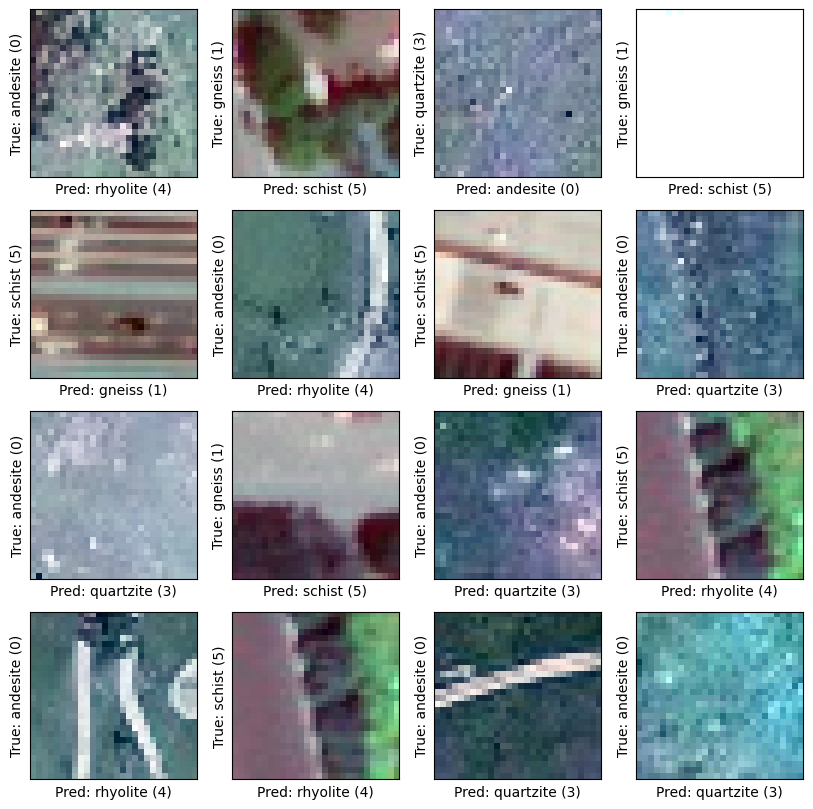

In [74]:
# plot side by side the image it predicts wrong and the true image

wrong_idx = np.where(y_pred != y_true)[0]
print(wrong_idx)
print(len(wrong_idx))
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = wrong_idx[i]

    img = test_dataset[idx][0]
    if img.min() < 0.:
          img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img.permute(1, 2, 0))
    plt.xlabel(f"Pred: {idx_to_class[y_pred[idx]]} ({y_pred[idx]})")
    plt.ylabel(f"True: {idx_to_class[y_true[idx]]} ({y_true[idx]})")
plt.show()

In [75]:
test_dataset[1]

(tensor([[[ 1.9704,  1.1690,  1.5486,  ...,  1.6541,  1.2745,  0.1146],
          [ 2.2024,  1.4854,  1.4643,  ...,  1.5697,  0.5153, -0.5813],
          [ 2.1391,  1.4221,  1.6541,  ...,  0.8316,  0.0302, -0.1807],
          ...,
          [ 1.4643,  1.4010,  1.3167,  ...,  1.5908,  1.6119,  1.6119],
          [ 1.4221,  1.4010,  1.3588,  ...,  1.5908,  1.5697,  1.5908],
          [ 1.4221,  1.4010,  1.4221,  ...,  1.5275,  1.5275,  1.5486]],
 
         [[ 1.6108,  0.9189,  1.3538,  ...,  1.6503,  1.1166, -0.0892],
          [ 1.7096,  1.1166,  1.1957,  ...,  1.4329,  0.3259, -0.7810],
          [ 1.4329,  0.8596,  1.2352,  ...,  0.5038, -0.2868, -0.5043],
          ...,
          [ 1.3933,  1.3340,  1.2550,  ...,  1.5119,  1.5317,  1.5317],
          [ 1.2945,  1.2747,  1.2352,  ...,  1.4526,  1.4922,  1.5119],
          [ 1.2945,  1.2747,  1.2945,  ...,  1.3933,  1.4526,  1.4724]],
 
         [[ 1.5155,  0.8704,  1.2467,  ...,  1.5514,  0.9780, -0.1868],
          [ 1.6768,  1.0855,

In [245]:
import torch
import matplotlib.pyplot as plt

def saliency(model, x, class_idx=None):
    model.eval()
    x_in = x.unsqueeze(0).to(device)
    x_in.requires_grad_(True)

    logits = model(x_in)
    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    score = logits[0, class_idx]
    grad = torch.autograd.grad(score, x_in)[0][0]          # (C,H,W)
    sal = grad.abs().max(dim=0)[0]                         # (H,W)
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal.detach().cpu()

def get_test_samples(model, dataset, num_classes, n_per_class, mode, is_pred=True):
    assert mode in {"correct", "wrong"}

    picked = {c: [] for c in range(num_classes)}  # store tuples (idx, true, pred)
    N = len(dataset)

    model.eval()
    with torch.no_grad():
        for i in range(N):
            x, y = dataset[i]

            pred = model(x.unsqueeze(0).to(device)).argmax(dim=1).item()

            ok = (pred == y) if mode == "correct" else (pred != y)
            if ok and len(picked[y]) < n_per_class:
              if is_pred:
                  picked[y].append((i, y, pred))
              else:
                  picked[y].append((x, y, i, pred))
    return picked

def plot_saliency_by_outcome(model, dataset, n_per_class=3, mode="correct"):
    base = dataset if hasattr(dataset, "classes") else dataset.dataset
    classes = base.classes
    num_classes = len(classes)
    picked = get_test_samples(model, dataset, num_classes, n_per_class, mode)

    fig, axes = plt.subplots(num_classes, n_per_class * 2,
                             figsize=(3 * n_per_class * 2, 2 * num_classes))
    fig.suptitle(f"Actual vs Overlayed Saliency Map ({mode.title()} Prediction) \n", fontweight="bold", fontsize=16)
    if num_classes == 1:
        axes = axes[None, :]

    for c in range(num_classes):
        for k in range(n_per_class):
            ax_img = axes[c, 2*k]
            ax_sal = axes[c, 2*k + 1]

            if k >= len(picked[c]):
                ax_img.axis("off"); ax_sal.axis("off")
                continue

            idx, y, pred = picked[c][k]
            x, _ = dataset[idx]

            img = x.detach().cpu()
            if img.min() < 0:
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)

            # saliency for the predicted class (what drove the model's decision)
            s = saliency(model, x, class_idx=pred)

            ax_img.imshow(img.permute(1,2,0))
            if mode == "correct":
                ax_img.set_title(f"{classes[y].title()}", fontsize=10, verticalalignment="center")
            else:
                ax_img.set_title(f"True: {classes[y]} \n Pred: {classes[pred]}", fontsize=10, verticalalignment="center")
            ax_img.axis("off")

            #---- UNCOMMENT THIS BIT IF YOU WANT TO SEE SALIENCY WITHOUT OVERLAY
            # ax_sal.imshow(s, cmap="magma", interpolation="bilinear")
            # ax_sal.set_title("Saliency (Overlay)", fontsize=10)

            ax_sal.imshow(img.permute(1, 2, 0))
            ax_sal.imshow(
                s,
                cmap="inferno",        # best perceptual colormap
                alpha=0.6,           # transparency
                interpolation="bilinear"
            )
            ax_sal.set_title("Saliency (Overlay)", fontsize=10, verticalalignment="center")
            ax_sal.axis("off")

    plt.tight_layout()
    plt.show()


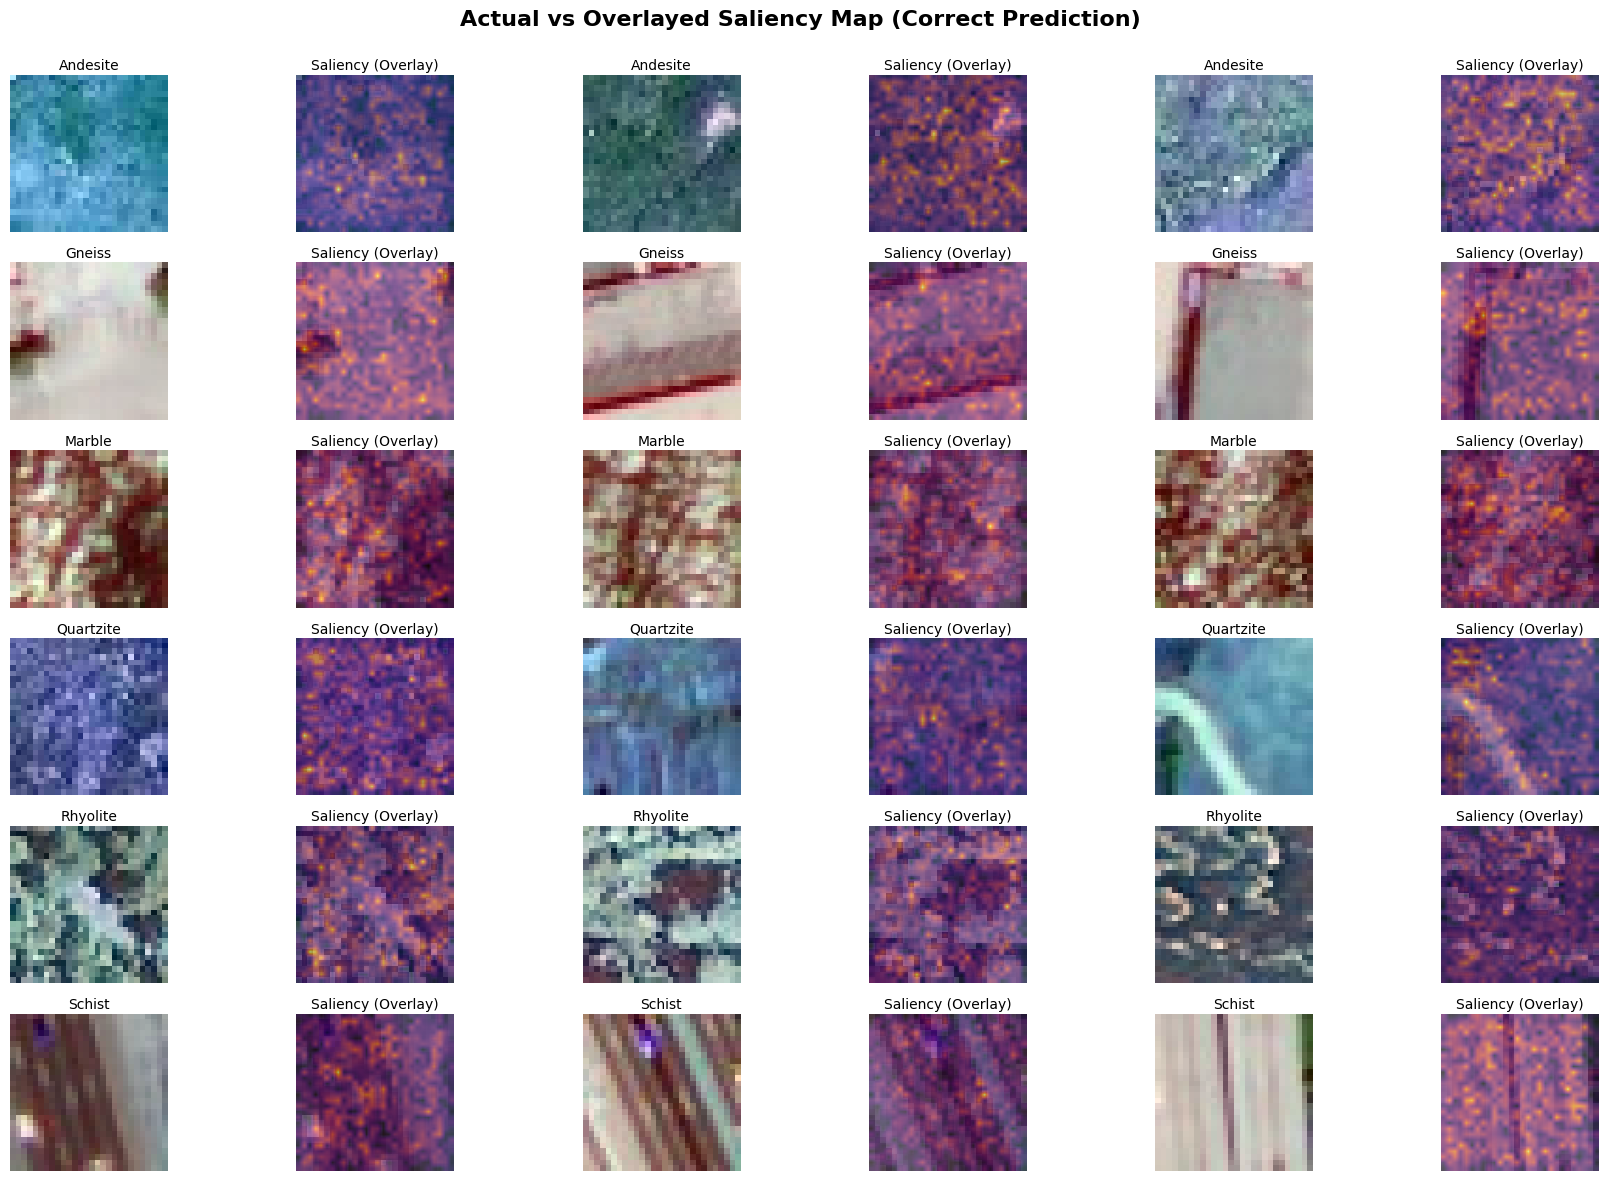

In [209]:
plot_saliency_by_outcome(
    small_cnn,
    test_dataset,
    n_per_class=3,
    mode="correct",
)

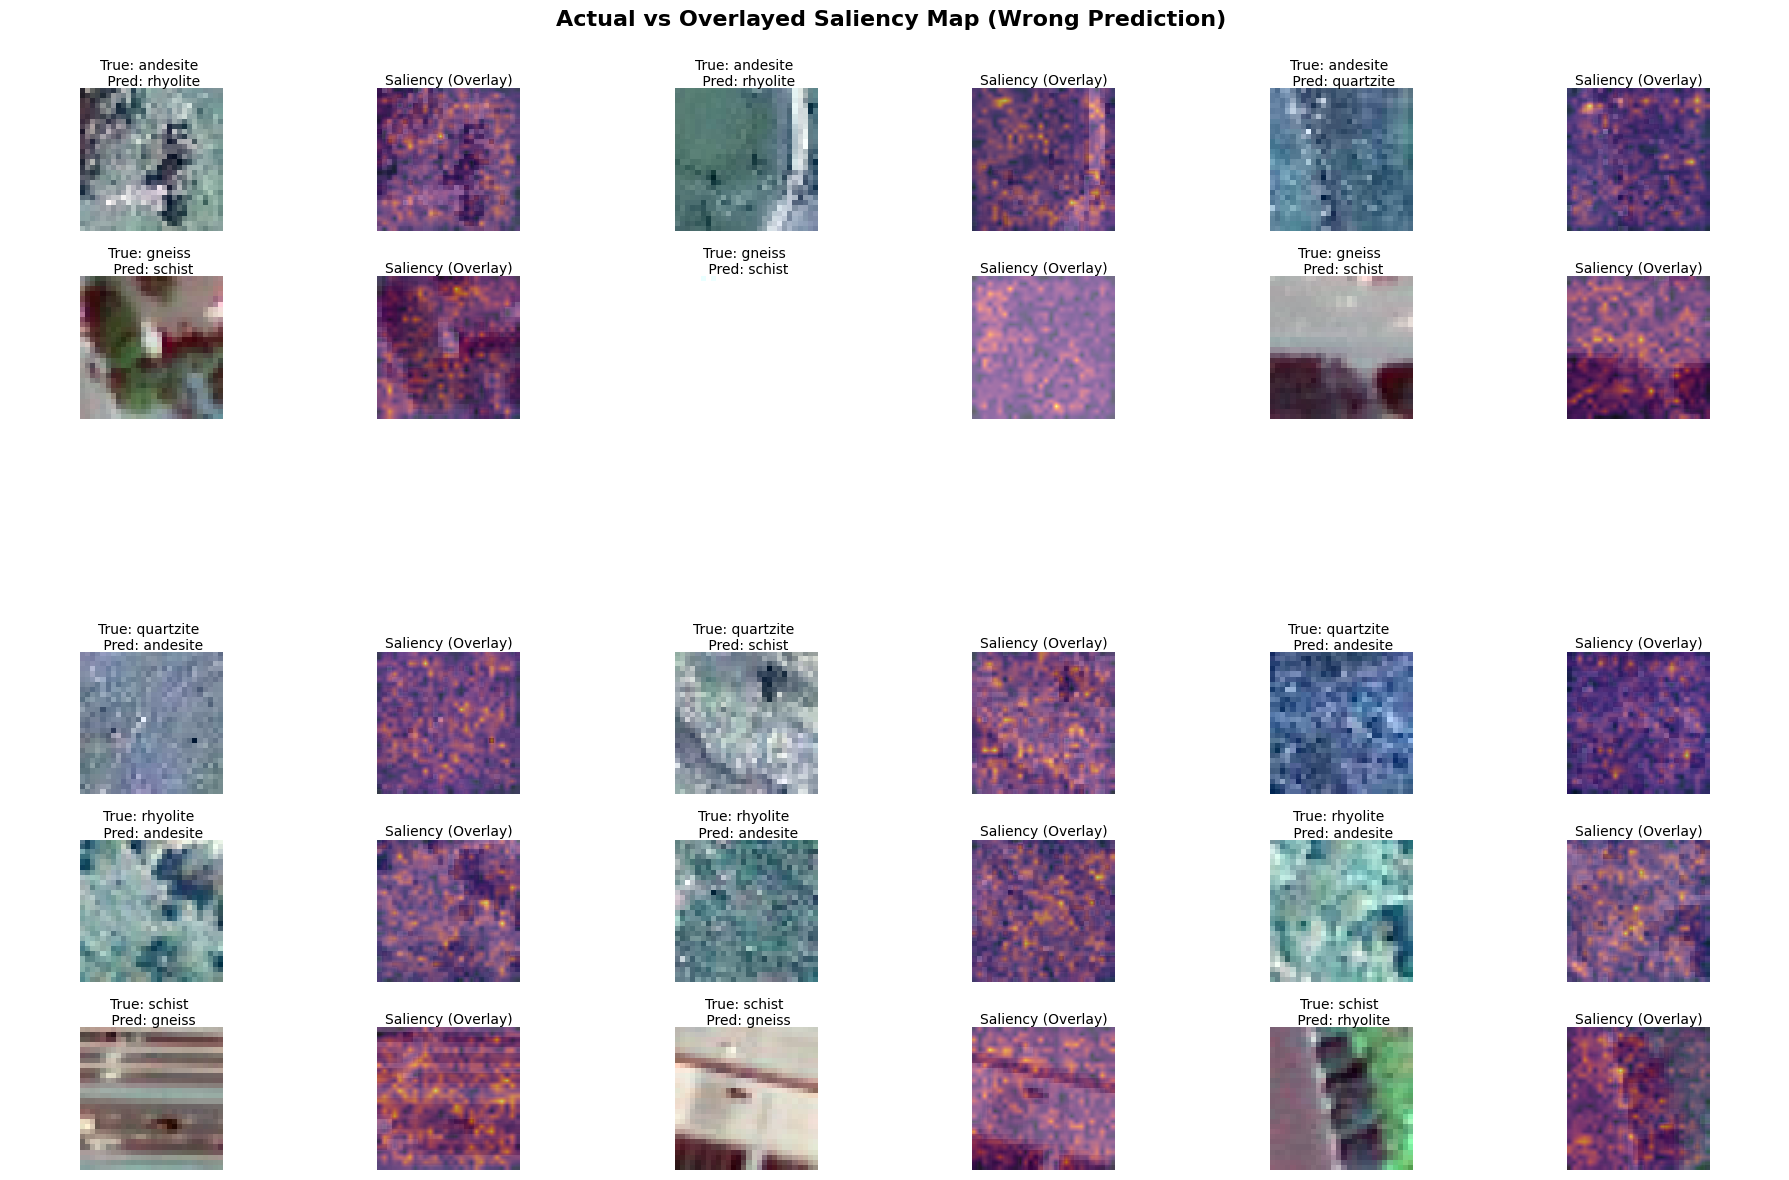

In [78]:
plot_saliency_by_outcome(small_cnn, test_dataset, n_per_class=3, mode="wrong")

In [132]:
def build_embedding_space(model, dataloader, device):
    """
    Returns:
        embeddings: (N, D) tensor
        labels:     (N,) tensor
    """
    model.eval()

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)

            h = model.features(x)
            h = h.view(h.size(0), -1)      # or model.flatten(h)
            emb = model.embedding(h)       # <-- embedding layer output
            emb = F.normalize(emb, dim=1)

            all_embeddings.append(emb.cpu())
            all_labels.append(y.cpu())

    embeddings = torch.cat(all_embeddings, dim=0)
    labels = torch.cat(all_labels, dim=0)

    return embeddings, labels

In [133]:
embeddings, labels = build_embedding_space(small_cnn, train_loader, device)

In [86]:
embeddings.shape, labels.shape

(torch.Size([20998, 256]), torch.Size([20998]))

In [115]:
from sklearn.decomposition import PCA
n_components = 50
pca = PCA(n_components=n_components)
embedding_space_projected = pca.fit_transform(embeddings)
embedding_space_projected.shape

(20998, 50)

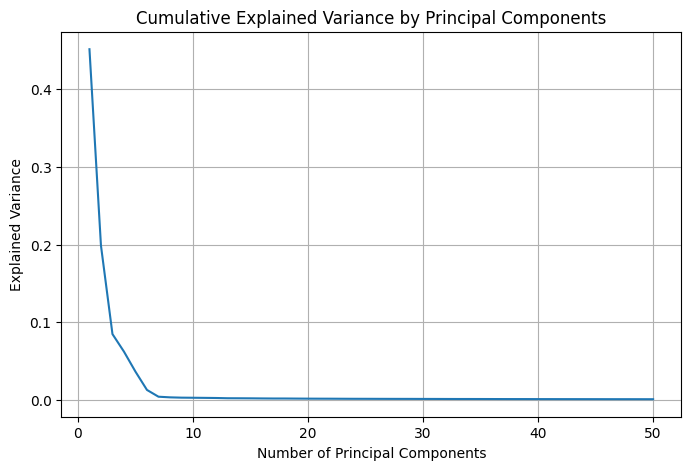

[0.45136885 0.19858876 0.08468698 0.06209999 0.03633412 0.01279931
 0.00407923 0.00326323 0.00286817 0.0027413  0.00259489 0.00243011
 0.00211122 0.00206561 0.00198879 0.00186132 0.00176676 0.00175945
 0.00167    0.00159153 0.00154182 0.00151312 0.00144687 0.00139273
 0.00137874 0.0013359  0.00130452 0.00128444 0.00127211 0.0012324
 0.00121338 0.00116984 0.00114121 0.00113696 0.00111626 0.00108429
 0.00105426 0.00103636 0.0010285  0.00100169 0.00099109 0.00097055
 0.00096082 0.00094256 0.00092865 0.00090374 0.0008919  0.00088708
 0.00086839 0.0008475 ]
[0.45136885 0.64995761 0.73464458 0.79674458 0.8330787  0.84587801
 0.84995724 0.85322047 0.85608863 0.85882993 0.86142482 0.86385493
 0.86596614 0.86803175 0.87002054 0.87188187 0.87364863 0.87540808
 0.87707807 0.8786696  0.88021142 0.88172454 0.88317141 0.88456414
 0.88594288 0.88727878 0.8885833  0.88986774 0.89113985 0.89237224
 0.89358562 0.89475546 0.89589667 0.89703363 0.89814989 0.89923418
 0.90028845 0.90132481 0.90235331 0.903

In [116]:
explained_variances = pca.explained_variance_ratio_
cumulative_explained_variances = explained_variances.cumsum()
plt.figure(figsize=(8,5))
plt.plot(range(1, n_components + 1), explained_variances)
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.grid()
plt.show()

print(explained_variances)
print(cumulative_explained_variances)

In [118]:
minimal_pc_count = (cumulative_explained_variances >= 0.90).argmax() + 1
print(f"Number of principal components to retain at least 90% variance: {minimal_pc_count}")

Number of principal components to retain at least 90% variance: 37


In [111]:
rock_dataset.classes

['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

In [130]:

def plot_embedding_2d(
    embedding_2d,
    labels,
    class_names,
    title="PCA: PC1 vs PC2",
    xlabel="PC 1",
    ylabel="PC 2",
    figsize=(8, 5),
    point_size=12,
    legend_loc="lower right"
):

    plt.figure(figsize=figsize)

    for cls_id, cls_name in enumerate(class_names):
        mask = (labels == cls_id)
        if mask.sum() == 0:
            continue
        plt.scatter(
            embedding_2d[mask, 0],
            embedding_2d[mask, 1],
            s=point_size,
            label=cls_name
        )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title="Class", loc=legend_loc)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

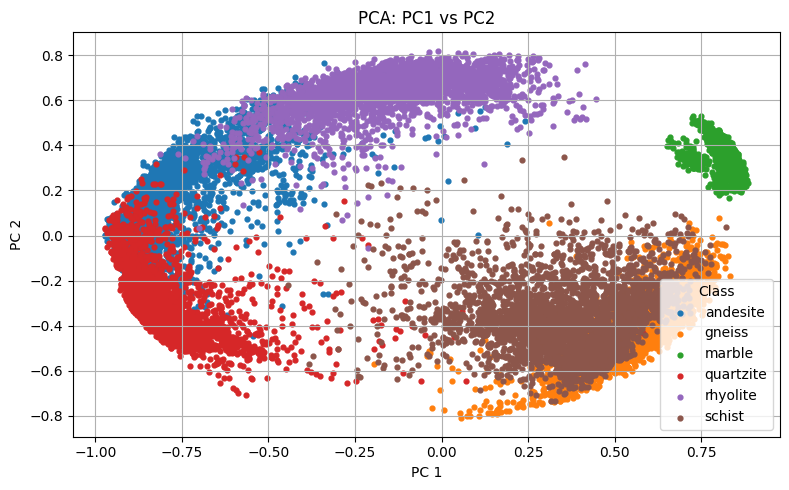

In [131]:
plot_embedding_2d(
    embedding_space_projected,
    labels,
    rock_dataset.classes
)

In [201]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(
    metric="cosine",
    algorithm="auto"
)

nn.fit(embeddings)     # embeddings shape: (N, D)

NearestNeighbors(metric='cosine')

In [328]:
sample_num = 3
top_neighbor_num = 5

In [329]:
test_sample_correct = get_test_samples(small_cnn, test_dataset, len(rock_dataset.classes), sample_num, "correct", is_pred=False)

In [330]:
def embed_test_samples(model, samples_dict, device):
    model.eval()
    embedded = {}

    with torch.no_grad():
        for cls_id, items in samples_dict.items():
            emb_list = []
            for x, y, idx, pred in items:
                x = x.unsqueeze(0).to(device)

                h = model.features(x)
                h = h.view(h.size(0), -1)
                emb = model.embedding(h)
                emb = F.normalize(emb, dim=1)

                emb_list.append((emb.cpu(), pred, y))

            embedded[cls_id] = emb_list

    return embedded

In [370]:
test_embeddings_correct = embed_test_samples(small_cnn, test_sample_correct, device)

In [381]:
import copy

def query_nn_for_test_embeddings(
    nn,
    test_embeddings,
    train_labels,
    class_names,
    topk=5
):
    data = copy.deepcopy(test_embeddings)
    for cls_id, emb_list in test_embeddings.items():
        print(f"\nQuery class: {class_names[cls_id]}")
        for i, (emb, pred, y) in enumerate(emb_list):
            distances, indices = nn.kneighbors(emb, n_neighbors=topk)
            neighbor_labels = train_labels[indices[0]]
            n = {}
            for el in range(len(neighbor_labels)):
                n[el] = {
                    "distance": distances[0][el],
                    "label": neighbor_labels[el],
                    "idx": indices[0][el],
                }
            data[cls_id][i] = (emb, pred, y, n)
            print(f"  Sample {i+1} (Pred: {class_names[pred]}): Nearest labels ->",
                  [class_names[l] for l in neighbor_labels])
    return data


In [383]:
test_embeddings_correct = query_nn_for_test_embeddings(
    nn,
    test_embeddings_correct,
    labels,
    rock_dataset.classes,
    topk=top_neighbor_num
)


Query class: andesite
  Sample 1 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']
  Sample 2 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']
  Sample 3 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']

Query class: gneiss
  Sample 1 (Pred: gneiss): Nearest labels -> ['gneiss', 'gneiss', 'gneiss', 'schist', 'gneiss']
  Sample 2 (Pred: gneiss): Nearest labels -> ['gneiss', 'gneiss', 'gneiss', 'gneiss', 'gneiss']
  Sample 3 (Pred: gneiss): Nearest labels -> ['gneiss', 'gneiss', 'gneiss', 'gneiss', 'gneiss']

Query class: marble
  Sample 1 (Pred: marble): Nearest labels -> ['marble', 'marble', 'marble', 'marble', 'marble']
  Sample 2 (Pred: marble): Nearest labels -> ['marble', 'marble', 'marble', 'marble', 'marble']
  Sample 3 (Pred: marble): Nearest labels -> ['marble', 'marble', 'marble', 'marble', 'marble']

Query class: quartzite
  Sample 1 

In [384]:
test_sample_wrong = get_test_samples(small_cnn, test_dataset, len(rock_dataset.classes), sample_num, "wrong", is_pred=False)

In [385]:
test_embeddings_wrong = embed_test_samples(small_cnn, test_sample_wrong, device)

In [386]:
test_embeddings_wrong = query_nn_for_test_embeddings(
    nn,
    test_embeddings_wrong,
    labels,
    rock_dataset.classes,
    topk=top_neighbor_num
)


Query class: andesite
  Sample 1 (Pred: rhyolite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'rhyolite']
  Sample 2 (Pred: rhyolite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']
  Sample 3 (Pred: quartzite): Nearest labels -> ['quartzite', 'quartzite', 'quartzite', 'quartzite', 'andesite']

Query class: gneiss
  Sample 1 (Pred: schist): Nearest labels -> ['schist', 'gneiss', 'schist', 'gneiss', 'schist']
  Sample 2 (Pred: schist): Nearest labels -> ['gneiss', 'gneiss', 'gneiss', 'gneiss', 'gneiss']
  Sample 3 (Pred: schist): Nearest labels -> ['schist', 'gneiss', 'schist', 'schist', 'schist']

Query class: marble

Query class: quartzite
  Sample 1 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']
  Sample 2 (Pred: schist): Nearest labels -> ['quartzite', 'quartzite', 'quartzite', 'quartzite', 'quartzite']
  Sample 3 (Pred: andesite): Nearest labels -> ['andesite', 'quartzite', 'a

In [387]:
test_sample_correct

{0: [(tensor([[[-0.2650, -0.8766, -0.9609,  ..., -0.9188, -0.8977, -0.8977],
            [-0.9609, -0.8133, -0.7711,  ..., -0.8766, -0.9188, -0.9820],
            [-0.8766, -0.7711, -0.8344,  ..., -0.8977, -0.9399, -0.9820],
            ...,
            [-0.7501, -0.7501, -0.7079,  ..., -0.9188, -0.8555, -0.8133],
            [-0.8977, -0.8766, -0.7922,  ..., -0.7711, -0.7711, -0.8133],
            [-0.9188, -0.8977, -0.7922,  ..., -0.6235, -0.6868, -0.7501]],
   
           [[-0.0101, -0.5833, -0.6229,  ..., -0.5043, -0.4845, -0.4845],
            [-0.6624, -0.5240, -0.4450,  ..., -0.4647, -0.5043, -0.5636],
            [-0.5240, -0.4252, -0.4845,  ..., -0.4845, -0.5240, -0.5636],
            ...,
            [-0.4054, -0.4054, -0.3857,  ..., -0.5833, -0.5240, -0.4845],
            [-0.5240, -0.5043, -0.4252,  ..., -0.4450, -0.4450, -0.4845],
            [-0.5438, -0.5240, -0.4252,  ..., -0.3066, -0.3659, -0.4252]],
   
           [[ 0.0820, -0.4377, -0.4377,  ..., -0.4018, -0.3839, -

In [388]:
test_embeddings_correct

{0: [(tensor([[ 5.9531e-02, -1.3424e-02, -1.5699e-01,  1.0936e-01,  8.8736e-03,
             1.6747e-02,  8.8791e-02, -5.1820e-02, -1.0747e-01, -1.0364e-01,
            -7.0917e-02, -3.1377e-02,  1.0831e-01, -1.4342e-02,  3.2212e-02,
             3.1954e-02,  4.1228e-02, -8.3151e-02,  1.8390e-02, -9.7723e-02,
            -6.5330e-02,  3.7350e-02,  6.6978e-02, -6.2795e-02, -1.3307e-01,
            -5.7671e-02, -7.7796e-03, -2.6263e-03,  2.0998e-02, -1.6104e-02,
            -8.7125e-02, -6.7263e-02,  6.7618e-02, -1.3854e-02,  1.0181e-01,
            -2.6079e-02, -3.0443e-02,  2.1950e-03, -1.4468e-02,  2.3012e-02,
            -2.0667e-02, -5.3681e-02, -8.5440e-03, -1.9665e-02,  2.6266e-03,
            -4.9194e-02,  5.0672e-02,  9.4246e-02,  4.4564e-02, -7.5509e-02,
            -5.4585e-02,  7.1851e-02, -7.1836e-02,  4.8270e-02, -1.4981e-01,
             4.6215e-02, -8.0097e-03,  8.4251e-03, -9.2481e-02,  3.1141e-02,
            -1.6322e-02, -6.2386e-02,  7.2630e-03, -3.6486e-02, -4.4966e-

In [ ]:
def plot_similarity(n_sample, sample_dataset):
  col = top_neighbor_num + 1 + 1
  row = len(rock_dataset.classes) * sample_num
  figure, axs = plt.subplots(nrow=row, ncol=col, figsize=(10, 10))
  for i, row in enumerate(axs):
    for j, ax in enumerate(row):
      if j == 0:
        ax.imshow(test_sample_correct[i][0][0].permute(1, 2, 0))
      ax.axis('off')
